## Prepare the environment and data

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .appName("Final Project") \
     .getOrCreate()
sc = spark.sparkContext      # get the context
sc

<SparkContext master=yarn appName=Final Project>

In [3]:
import pandas as pd

In [4]:
features = spark.read.format("csv").option("header", "true").load("s3://anly502final/fma_dataset/fma_dataset.csv")

In [5]:
tracks = spark.read.format("csv").option("header", "true").load("s3://anly502final/fma_dataset/tracks.csv")

In [6]:
#Combine two csv file by tracks_id column
Join_table = features.join(tracks["track_id","genre_top"], features.feature == tracks.track_id)

In [7]:
#convert the type of track_id column into integer
from pyspark.sql.types import *
Join_table = Join_table.withColumn("track_id", Join_table["track_id"].cast(IntegerType()))

In [8]:
#order by track_id column
from pyspark.sql.functions import col
Join_table = Join_table.orderBy(Join_table.track_id)

In [9]:
#delete duplicate column
Join_table = Join_table.drop('feature')

#### .printSchema()

There are 520 columns in the following dataframe. 
The first 518 columns are features extracted by LibROSA, which is a python package for music and audio analysis. 
The last two columns are respectively the identity column "track_id" and the target variable "genre_top".

In [10]:
Join_table.printSchema()

root
 |-- chroma_cens1: string (nullable = true)
 |-- chroma_cens2: string (nullable = true)
 |-- chroma_cens3: string (nullable = true)
 |-- chroma_cens4: string (nullable = true)
 |-- chroma_cens5: string (nullable = true)
 |-- chroma_cens6: string (nullable = true)
 |-- chroma_cens7: string (nullable = true)
 |-- chroma_cens8: string (nullable = true)
 |-- chroma_cens9: string (nullable = true)
 |-- chroma_cens10: string (nullable = true)
 |-- chroma_cens11: string (nullable = true)
 |-- chroma_cens12: string (nullable = true)
 |-- chroma_cens13: string (nullable = true)
 |-- chroma_cens14: string (nullable = true)
 |-- chroma_cens15: string (nullable = true)
 |-- chroma_cens16: string (nullable = true)
 |-- chroma_cens17: string (nullable = true)
 |-- chroma_cens18: string (nullable = true)
 |-- chroma_cens19: string (nullable = true)
 |-- chroma_cens20: string (nullable = true)
 |-- chroma_cens21: string (nullable = true)
 |-- chroma_cens22: string (nullable = true)
 |-- chroma_ce

Create a TempView and filter out distinct values of target variables:

We selected the top 13 categories of genre label: 
1. Experimental
2. Electronic
3. Rock
4. Instrumental
5. Pop
6. Folk
7. Hip-Hop
8. International
9. Jazz
10. Classical
11. Country
12. Spoken
13. Blues

In [11]:
Join_table.createOrReplaceTempView("Join_table")

In [12]:
cleaned_df = spark.sql("select * from Join_table where genre_top in ('Experimental','Electronic','Rock','Instrumental','Pop','Folk','Hip-Hop','International','Jazz','Classical','Country','Spoken','Blues') ")

#### cleaned_df
This dataframe now has an identity column, a label column and 518 feature columns for feature engineering and modeling.

In [13]:
cleaned_df.count() # The No. of row of the dataframe

11105

The number of rows now decreases drastically, because there are a lot of missing values in this column.

## Exploratory data analysis

In [14]:
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np
import seaborn as sns

### 1. Check the balance of the target variable

In [15]:
import pyspark.sql.functions as F
from pyspark.sql.functions import bround
check_balance = cleaned_df.groupBy("genre_top").count()
check_balance = check_balance.withColumn("Percentage",bround(F.col("count")/11105,2))

In [16]:
check_balance.show()

+-------------+-----+----------+
|    genre_top|count|Percentage|
+-------------+-----+----------+
|International|  276|      0.02|
| Instrumental|  689|      0.06|
|         Rock| 2557|      0.23|
|         Jazz|  125|      0.01|
|         Folk|  919|      0.08|
|    Classical|  160|      0.01|
|        Blues|   13|       0.0|
| Experimental| 1993|      0.18|
|       Spoken|   64|      0.01|
|          Pop|  554|      0.05|
|   Electronic| 3069|      0.28|
|      Country|   68|      0.01|
|      Hip-Hop|  618|      0.06|
+-------------+-----+----------+



In [17]:
check_balance = check_balance.toPandas()

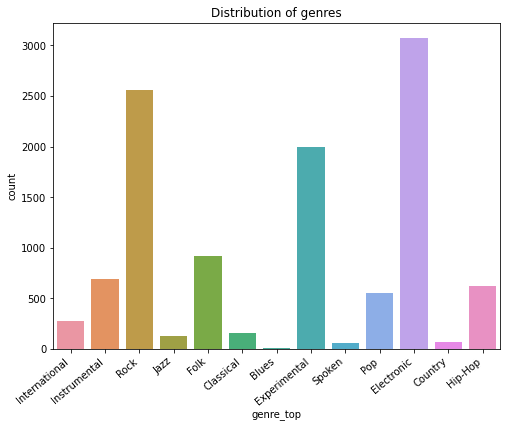

In [18]:
fig = plt.figure(figsize=(8,6))
ax = sns.barplot(x="genre_top", y="count", data=check_balance)
ax.set_title("Distribution of genres")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

The data is not very balanced, The "Rock" label, "Electorinic' label and 'Experimental' label take up 70% among all labels and all other label types only take up 30%.

### 2. Check the collinearity of features

#### The features we selected for supervised learning temporarily:
 
1. chroma_cens1
2. chroma_cqt85
3. chroma_stft169
4. mfcc253
5. spectral_bandwidth400
6. spectral_centroid407
7. spectral_contrast414
8. spectral_rolloff463
9. tonnetz470
10. zcr512

In [19]:
features = ['chroma_cens1', 'chroma_cqt85', 'chroma_stft169', 'mfcc253', 'spectral_bandwidth400',
           'spectral_centroid407', 'spectral_contrast414', 'spectral_rolloff463', 'tonnetz470', 
           'zcr512']

myGraph=cleaned_df[features]
for col in features:
    myGraph = myGraph.withColumn(col,myGraph[col].cast(DoubleType()))

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=features, 
                            outputCol=vector_col)
myGraph_vector = assembler.transform(myGraph).select(vector_col)
matrix = Correlation.corr(myGraph_vector, vector_col)

matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray()

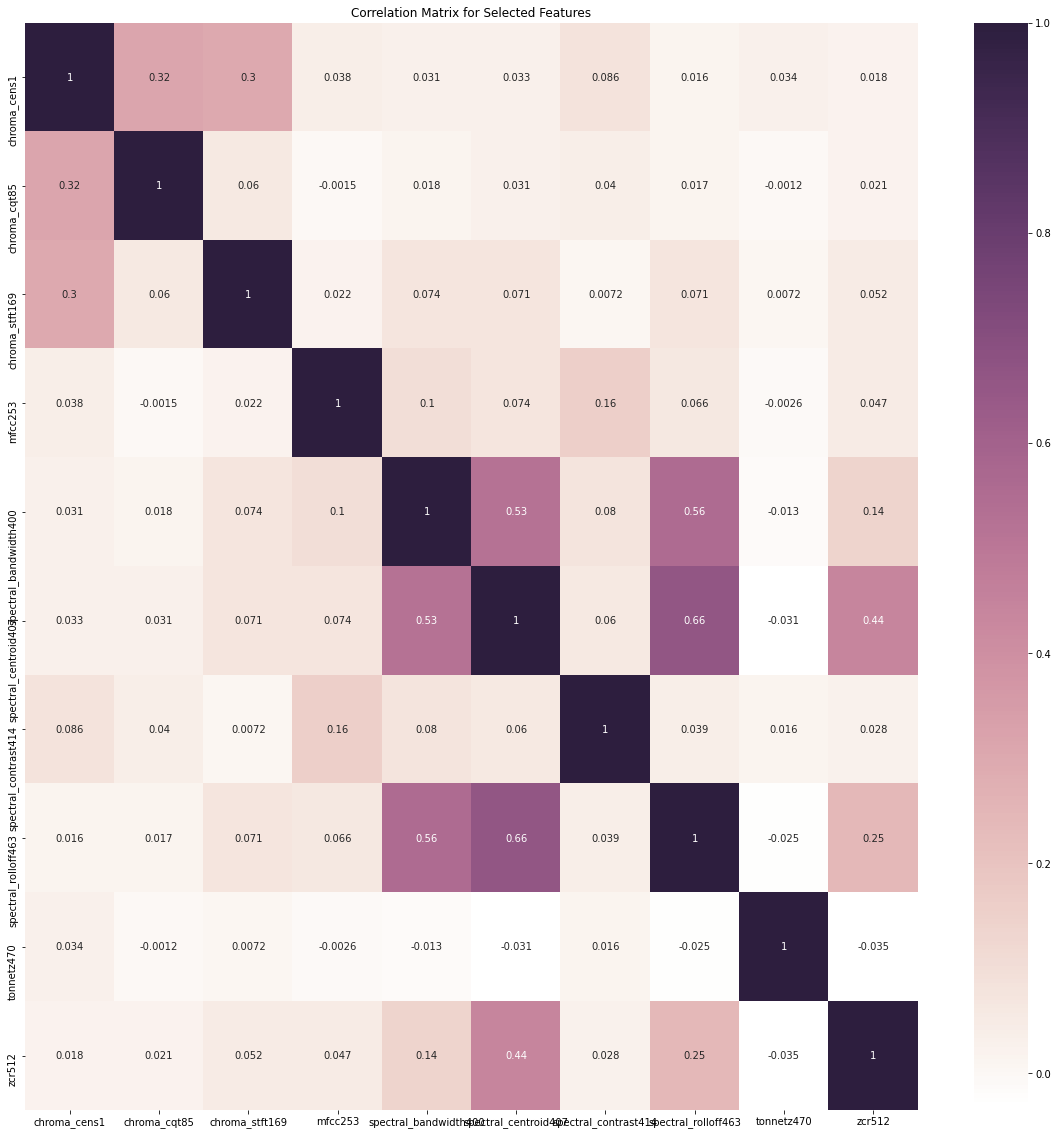

In [20]:
fig = plt.figure(figsize=(20,20))
cmap = sns.cubehelix_palette(light=1, as_cmap = True)
ax = sns.heatmap(corrmatrix, annot=True, cmap = cmap)
ax.set_title("Correlation Matrix for Selected Features")
ax.set_xticklabels(features)
ax.set_yticklabels(features)
plt.show()

Fome the above correlation plot, we can conclude that feature 'spectral_rolloff463' have a relatively strong and positive relationship with spectral_bandwidth400' and 'spectral_centroid407', while others are weakly or not correlated. So we decide to exclude this feature when conduct machine learning models.

Therefore, the features selected for now is:

1. chroma_cens1
2. chroma_cqt85
3. chroma_stft169
4. mfcc253
5. spectral_bandwidth400
6. spectral_centroid407
7. spectral_contrast414
8. tonnetz470
9. zcr512

### 3. Check the distribution of features

In [21]:
features = ['chroma_cens1', 'chroma_cqt85', 'chroma_stft169', 'mfcc253', 'spectral_bandwidth400',
           'spectral_centroid407', 'spectral_contrast414', 'tonnetz470', 'zcr512']

In [22]:
df = cleaned_df.toPandas()
new_df = pd.DataFrame(df['genre_top'])
for col in features:
    new_df[col] = df[col]

In [23]:
for col in features:
    new_df[col] = pd.to_numeric(new_df[col], errors='coerce')

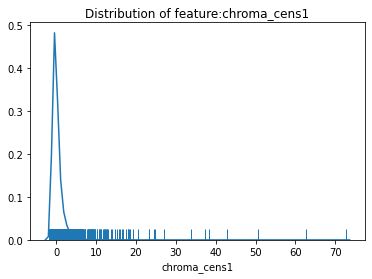

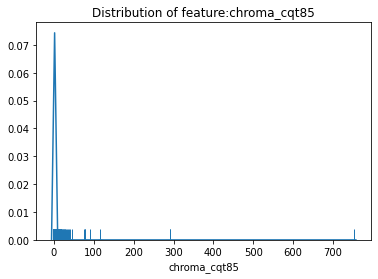

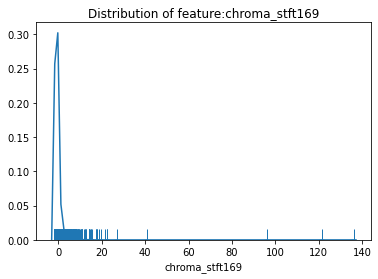

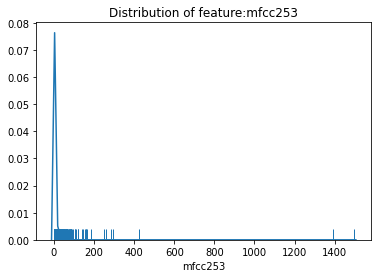

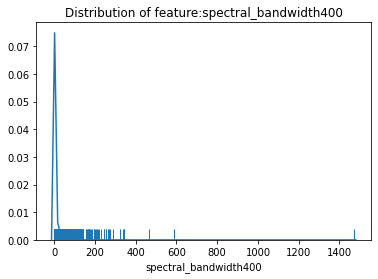

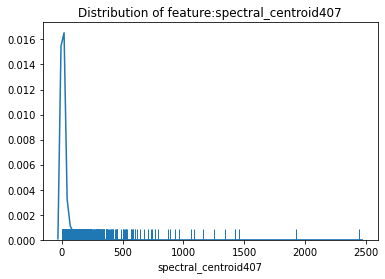

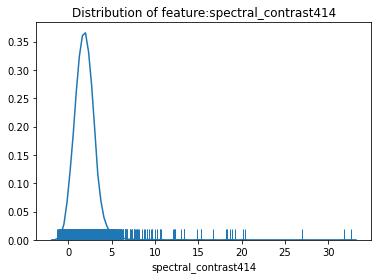

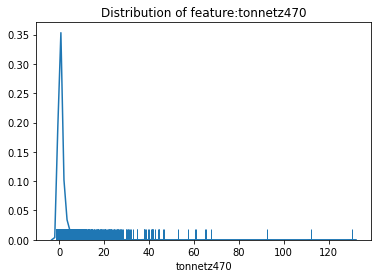

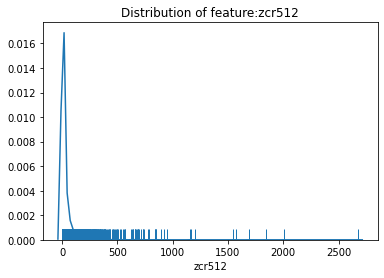

In [24]:
for col in features:
    fig = plt.figure(figsize=(6,4))   
    ax = sns.distplot(new_df[col], hist=False, rug=True)
    ax.set_title(f"Distribution of feature:{col}")
    #ax.set(xlim=(-5, 5))
    plt.show()

From the above plots, we can conclude that the distribution of all features are highly skewed to the right,and there are outliers for each feature, but since there are infinite possible ways to make a song, they are not exactly "outliers", so we will keep those numbers this time.

## Unsupervised Learning

## Modelling

In [37]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model
from pyspark.ml.feature import StringIndexer

Append a new Column called label which maps the types Album, Live Performance, Single Tracks, Radio Program to 1, 2, 3, 4 respectively. 

In [39]:
def convert(line):
    try:
        if line == 'Album':
            return 1
        elif line == 'Live Performance':
            return 2
        elif line == 'Single Tracks':
            return 3
        elif line == 'Radio Program':
            return 4
    except:
        return 0
    

In [41]:
new_df['label'] = new_df['type'].apply(convert)
